In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 4.2 MB/s 


In [2]:
import pandas as pd
import numpy as np
import tweepy
import matplotlib.pyplot as plt

# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Machine Learning imports
import nltk
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
import joblib
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

import string
import re
from string import punctuation
from collections import Counter

## 2. GET & Explore Data

In [3]:
# Call twitter api keys
consumer_key = 'GCTZ311qVSOFTA6WaYr8kOBpy'
consumer_secret = '9xqIpuzQDZDBq9QBRvMmvqfd7JypN6TpZAETAYPO558v9GW6m8'
access_token = '1453916526-mSyAXo7voiQ2IUGd0sUxqcAB63wCPD9ZInPGS38'
access_secret = 'yTDg7AinKFXtJAWmAOHhOJVKPD0mZw6zKI1RRJPm3gpyg'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth)

In [4]:
# Search keywords
tweets = tweepy.Cursor(api.search,q='halodoc)',tweet_mode="extended",since="2022-03-11",lang="id").items(1000)
message,retweet_count,retweet,created_at,user_name,user_id=[],[],[],[],[],[]
count = 0
for tweet in tweets:
    count=count+1
    if hasattr(tweet, 'retweeted_status'):
        message.append(tweet.retweeted_status.full_text)
        retweet_count.append(tweet.retweet_count)
        retweet.append(tweet.retweeted_status.user.screen_name)
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.screen_name)
        user_id.append(tweet.user.id)
    else:
        message.append(tweet.full_text)
        retweet_count.append(tweet.retweet_count)
        retweet.append(print(''))
        created_at.append(tweet.created_at)
        user_name.append(tweet.user.screen_name)
        user_id.append(tweet.user.id)
# insert tweets to database
for i in range(count):
    data=[message[i], retweet_count[i], retweet[i], created_at[i], user_name[i], user_id[i]]

In [5]:
# make dataframe
df=pd.DataFrame({
    'author':retweet,
    'username':user_name,
    'retweet_count':retweet_count,
    'tweets':message,
    'created_at':created_at
})
df = df.sort_values(['created_at'], ascending=[0])

In [6]:
df

,author,username,retweet_count,tweets,created_at
0,None,hanmsywll_,0,"Oke menurut artikel di Halodoc, ada banyak sek...",2022-11-14 15:45:30
1,HalodocID,MIF09,227,BAGI-BAGI HADIAH GOPAY TOTAL 500RB! 🤩✨\n\nCara...,2022-11-14 15:45:29
2,None,MIF09,0,@HalodocID Ada 12 Logo @HalodocID pada Gambar....,2022-11-14 15:45:21
3,None,macaupop,0,@yutabantul konsul via halodoc ya kak,2022-11-14 15:36:30
4,None,ratnadwift,0,@kochengfs Aku juga waktu itu kena kaya gini. ...,2022-11-14 15:31:55
...,...,...,...,...,...
154,HalodocID,tertinju,227,BAGI-BAGI HADIAH GOPAY TOTAL 500RB! 🤩✨\n\nCara...,2022-11-14 00:13:33
155,None,surekoy,0,Terbaik emg ieu halodoc keur hupir teh 😌,2022-11-14 00:04:53
156,HalodocID,CakSar_,227,BAGI-BAGI HADIAH GOPAY TOTAL 500RB! 🤩✨\n\nCara...,2022-11-13 23:30:12
157,None,CakSar_,0,@HalodocID Bismillah semoga beruntung.\nJawaba...,2022-11-13 23:30:07


In [9]:
df

,author,username,retweet_count,tweets,created_at
0,None,hanmsywll_,0,"Oke menurut artikel di Halodoc, ada banyak sek...",2022-11-14 15:45:30
1,HalodocID,MIF09,227,BAGI-BAGI HADIAH GOPAY TOTAL 500RB! 🤩✨\n\nCara...,2022-11-14 15:45:29
2,None,MIF09,0,@HalodocID Ada 12 Logo @HalodocID pada Gambar....,2022-11-14 15:45:21
3,None,macaupop,0,@yutabantul konsul via halodoc ya kak,2022-11-14 15:36:30
4,None,ratnadwift,0,@kochengfs Aku juga waktu itu kena kaya gini. ...,2022-11-14 15:31:55
...,...,...,...,...,...
154,HalodocID,tertinju,227,BAGI-BAGI HADIAH GOPAY TOTAL 500RB! 🤩✨\n\nCara...,2022-11-14 00:13:33
155,None,surekoy,0,Terbaik emg ieu halodoc keur hupir teh 😌,2022-11-14 00:04:53
156,HalodocID,CakSar_,227,BAGI-BAGI HADIAH GOPAY TOTAL 500RB! 🤩✨\n\nCara...,2022-11-13 23:30:12
157,None,CakSar_,0,@HalodocID Bismillah semoga beruntung.\nJawaba...,2022-11-13 23:30:07


In [8]:
df.to_csv('halodoc.csv')

## 3. Preprocessing Data

### 3.1 Case Folding

In [10]:
# helper function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove Punctuation and split 's, 't, 've with a space for filter
    tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    return tweet

In [11]:
# clean dataframe's text column
df['tweets'] = df['tweets'].apply(processTweet)
# preview some cleaned tweets
df[['tweets']].head()

,tweets
0,oke menurut artikel halodoc ada banyak sekali ...
1,bagi bagi hadiah gopay total 500rb ✨ caranya s...
2,ada logo pada gambar yuk ikutan
3,konsul via halodoc kak
4,aku juga waktu itu kena kaya gini kata dokter ...


In [12]:
# drop duplicates
df = df.drop_duplicates('tweets')
df.shape

(103, 5)

### 3.2 Case Folding

In [13]:
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [14]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()
 
def stoptweet(tweet):
  tweet = stopword.remove(tweet)
  replace_list = ['dan', 'yang', 'untuk','dari','ini','dengan','karena','pada','dalam','itu','aku','kamu','klikdokter','kalo','aja']
  tweet = re.sub(r'|'.join(map(re.escape, replace_list)), '', tweet)
  return tweet

In [15]:
df['tweets'] = df['tweets'].apply(stoptweet)
# preview some cleaned tweets
df[['tweets']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tweets
0,oke artikel halodoc banyak sekali manfaat menu...
1,bagi hadiah gopay total 500rb ✨ caranya super ...
2,logo gambar yuk ikutan
3,konsul via halodoc kak
4,waktu kena kaya g kata dokter sih jamur kucin...


### 3.3 Stemming

In [16]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [17]:
# helper function to clean tweets
def stemtweet(tweet):
  tweet = stemmer.stem(tweet)
  return tweet

In [18]:
# clean dataframe's text column
df['tweets'] = df['tweets'].apply(stemtweet)
# preview some cleaned tweets
df[['tweets']].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,tweets
0,oke artikel halodoc banyak sekali manfaat tuli...
1,bagi hadiah gopay total 500rb cara super gampi...
2,logo gambar yuk ikut
3,konsul via halodoc kak
4,waktu kena kaya g kata dokter sih jamur kucing...


### 3.4 Tokenizing

In [19]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
lst = set(stopwords.words('english'))
lst = [x.strip() for x in lst] 
# tokenize helper function
def text_process(raw_text):
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in lst]

# -------------------------------------------

# tokenize message column and create a column for tokens
df['tokens'] = df['tweets'].apply(text_process) # tokenize style 1
df = df[['tweets','tokens']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [21]:
df.head()

,tweets,tokens
0,oke artikel halodoc banyak sekali manfaat tuli...,"[oke, artikel, halodoc, banyak, sekali, manfaa..."
1,bagi hadiah gopay total 500rb cara super gampi...,"[bagi, hadiah, gopay, total, 500rb, cara, supe..."
2,logo gambar yuk ikut,"[logo, gambar, yuk, ikut]"
3,konsul via halodoc kak,"[konsul, via, halodoc, kak]"
4,waktu kena kaya g kata dokter sih jamur kucing...,"[waktu, kena, kaya, g, kata, dokter, sih, jamu..."


In [22]:
df.to_csv('tweets_halodoc_clean.csv')

## 4. Word Cloud

In [23]:
all_words = []
for line in df['tokens']: 
    all_words.extend(line)  
# create a word frequency dictionary
wordfreq = Counter(all_words)
wordfreq.most_common(10)

[('halodoc', 84),
 ('obat', 22),
 ('dokter', 18),
 ('konsul', 17),
 ('logo', 15),
 ('sehat', 15),
 ('gak', 14),
 ('buat', 12),
 ('jawab', 11),
 ('sama', 11)]

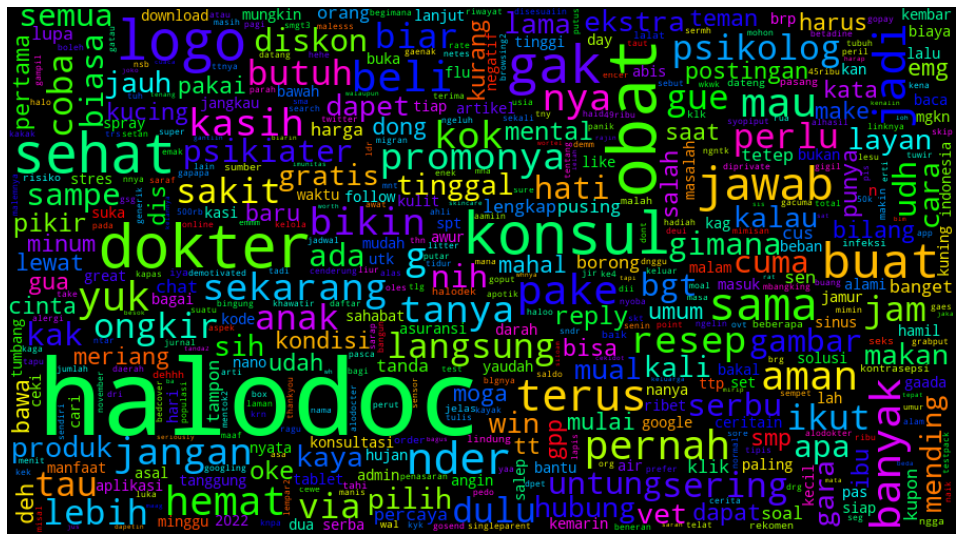

In [24]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='gist_rainbow',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Review google playstore

In [26]:
!pip install google_play_scraper
!pip install app_store_scraper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from google_play_scraper import app, Sort, reviews_all, reviews
from app_store_scraper import AppStore
import pandas as pd
import numpy as np
import json, os, uuid

In [28]:
g_reviews, continuation_token = reviews(
    'id.codigo.klikdokter',
    lang='en', # defaults to 'en'
    country='us', # defaults to 'us'
    sort=Sort.NEWEST, # defaults to Sort.NEWEST
    count=10000, # defaults to 100
    filter_score_with=(1 or 2 or 3)# defaults to None(means all score)
    )


g_df = pd.DataFrame(np.array(g_reviews),columns=['review'])
g_df2 = g_df.join(pd.DataFrame(g_df.pop('review').tolist()))

g_df2.drop(columns={'userImage', 'reviewCreatedVersion'},inplace = True)
g_df2.rename(columns= {'score': 'rating','userName': 'user_name', 'reviewId': 'review_id', 'content': 'review_description', 'at': 'review_date', 'replyContent': 'developer_response', 'repliedAt': 'developer_response_date', 'thumbsUpCount': 'thumbs_up'},inplace = True)
g_df2.insert(loc=0, column='source', value='Google Play')
g_df2.insert(loc=3, column='review_title', value=None)
g_df2['laguage_code'] = 'id'
g_df2['country_code'] = 'id'




In [29]:
a_reviews = AppStore('id', 'halodoc-doctors-medicines', '1067217981')
a_reviews.review(how_many=10000)
a_df = pd.DataFrame(np.array(a_reviews.reviews),columns=['review'])
a_df2 = a_df.join(pd.DataFrame(a_df.pop('review').tolist()))

a_df2.insert(loc=0, column='source', value='App Store')
a_df2['developer_response_date'] = None
a_df2['thumbs_up'] = None
a_df2['laguage_code'] = 'id'
a_df2['country_code'] = 'id'
a_df2.insert(loc=1, column='review_id', value=[uuid.uuid4() for _ in range(len(a_df2.index))])
a_df2.rename(columns= {'review': 'review_description','userName': 'user_name', 'date': 'review_date','title': 'review_title', 'developerResponse': 'developer_response'},inplace = True)
a_df2 = a_df2.where(pd.notnull(a_df2), None)

ERROR:Base:Something went wrong: HTTPSConnectionPool(host='amp-api.apps.apple.com', port=443): Max retries exceeded with url: /v1/catalog/id/apps/1067217981/reviews?l=en-GB&offset=2000&limit=20&platform=web&additionalPlatforms=appletv%2Cipad%2Ciphone%2Cmac (Caused by ResponseError('too many 429 error responses'))


In [30]:
result = pd.concat([g_df2,a_df2])
result

,source,review_id,user_name,review_title,review_description,rating,thumbs_up,review_date,developer_response,developer_response_date,laguage_code,country_code,isEdited
0,Google Play,efe3a1ab-ab19-439b-a9b3-0881bd2e62a4,Deddy apriadi,None,Aplikasi gak bener. Udah bayar mau konsultasi....,1,0,2022-11-08 20:57:47,"Dear Deddy apriadi, terima kasih telah meluang...",2022-11-08 21:05:24,id,id,NaN
1,Google Play,949adfe4-aa89-4ab7-aa93-862a54854fad,Aulia Abdurrahman,None,"semenjak UI baru, skrng jadi susah. Sdh pembay...",1,5,2022-10-29 15:57:06,"Hai Aulia Abdurrahman, terima kasih sudah melu...",2022-10-29 20:06:08,id,id,NaN
2,Google Play,b1e747d4-45aa-4631-931b-2c0f82459b2c,Ariyanto,None,Doctor end the conversation in the middle of c...,1,1,2022-10-12 04:26:42,"Hai Ariyanto, terima kasih sudah meluangkan wa...",2022-10-04 14:01:40,id,id,NaN
3,Google Play,2dfb2970-3fbd-4751-9a75-f090047742f9,Amelia Hakim,None,Aplikasi error terus. Tidak jelas. Gak recomme...,1,2,2022-10-07 05:40:17,"Hai Amelia Hakim, mohon maaf atas ketidaknyama...",2022-10-07 06:05:08,id,id,NaN
4,Google Play,a2adffea-d7af-43ab-b1bc-7ada05a4552f,Mnd Hkm,None,Aplikasi yang sering error dan sangat tidak me...,1,1,2022-10-07 05:26:33,"Hai Mnd Hkm, mohon maaf atas ketidaknyamananny...",2022-10-07 06:04:42,id,id,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,App Store,409c9203-96f3-41b9-a927-2d41ee5bbdf1,Yang penting hayu meluncur,Merasa senang,"Ngebantu bgt aseli, ngga kudu repot-repot ke p...",5,None,2020-10-17 09:50:07,"{'id': 18547672, 'body': 'Hai Yang penting hay...",NaT,id,id,False
1996,App Store,e2c55a31-2b4b-48c6-8fed-b0b0db9b4bbf,sari indira,Lansia,Terimakasih dokter cantik yg baik tidak smbong,5,None,2020-10-16 13:50:25,"{'id': 18541693, 'body': 'Hai sari indira! Ter...",NaT,id,id,False
1997,App Store,3d1415f1-dd6e-4e0e-9e90-1c81907ae92a,anisya intan n,good,alhamdulillah sejauh ini merasa puas dengan pe...,4,None,2020-10-17 03:35:37,"{'id': 18543909, 'body': 'Hai anisya intan n! ...",NaT,id,id,False
1998,App Store,976541da-9430-4a5a-8865-b35e26fc79f6,Veriajah,Dokternya bagus,Dokternya bagus..detail\nRecomend,5,None,2020-10-15 16:54:00,"{'id': 18534800, 'body': 'Hai Veriajah! Terima...",NaT,id,id,False


In [31]:
result.to_csv('review_playstore.csv')

In [ ]:
a_df2

,source,review_id,review_description,review_title,isEdited,developer_response,rating,review_date,user_name,developer_response_date,thumbs_up,laguage_code,country_code
0,App Store,249fe131-c623-4296-9cc8-40b95876ebcc,Sangat membantuu,Terimakasij,False,"{'id': 12913402, 'body': 'Hai ai yuli! Terima ...",5,2020-01-14 14:27:12,ai yuli,None,None,id,id
1,App Store,d4d23bbb-2eeb-493c-86a1-3a2da4720170,Saya kecewa sekali.. obat anak saya menurut fa...,Kecewa banget,False,"{'id': 7250117, 'body': 'Hai Devithiam! Mohon ...",1,2019-02-11 18:02:26,devithiam,None,None,id,id
2,App Store,3e089e97-7748-4154-a4c4-a48c4c3df6bf,"Saya chat dgn salah satu dokter, yg sudah peng...",Pengetahuan umum Dokter,False,"{'id': 14429201, 'body': 'Hai LAA25! Mohon maa...",5,2020-04-02 23:42:02,LAA25,None,None,id,id
3,App Store,f1ed624f-9bce-4820-858f-755e9e6850d0,My halodoc app forces close everytime I tried ...,Please Fix Update for iOS 14,True,"{'id': 17963983, 'body': 'Hai atsiyi! Mohon ma...",5,2020-10-05 04:16:37,atsiyi,None,None,id,id
4,App Store,a91d9f82-8a47-4b63-acb9-01129d2dcc26,Saya melakukan orderan melalui halodoc dengan ...,Sangat kecewa,False,"{'id': 14447381, 'body': 'Hai Syahril Reza! Mo...",1,2020-04-03 18:26:59,syahril reza,None,None,id,id
...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,App Store,1bf87eb8-4af8-49a5-b4e9-da132b6713d0,Dokter sangat fast response dan ramah. Semoga ...,Fast response,False,"{'id': 30545659, 'body': 'Hai Rizky Azhar! Ter...",5,2022-06-23 14:45:59,Rizky Azhar,None,None,id,id
316,App Store,772a1072-1b08-466f-8fa8-318881bce2b3,Alamat tidak bisa isi manual. Hasilnya pilih m...,Mapnya kacau salah terus,False,"{'id': 30553968, 'body': 'Hai DMRNSJ! Mohon ma...",3,2022-06-24 13:44:33,DMRNSJ,None,None,id,id
317,App Store,744b95c4-cb0f-4ca1-9cdd-11e30b8c16f2,Kenapa si iphone 6 gak bisa harus ios 13 pdaha...,Kenapa harus ios 13,False,"{'id': 30551558, 'body': 'Hai ganesgege! Mohon...",3,2022-06-24 12:53:07,ganesgege,None,None,id,id
318,App Store,f94408a2-5937-4f77-9855-7f25113eb3e9,But somehow the app lag a little bit.,Super convenience,False,"{'id': 30533783, 'body': 'Hai Nabila Nutriarsi...",5,2022-06-23 03:29:56,Nabila Nutriarsita,None,None,id,id


In [ ]:
test=pd.concat([result[result['review_description'].str.contains('langganan')],result[result['review_description'].str.contains('subscribe')],result[result['review_description'].str.contains('subscription')]])
print("\n".join(test["review_description"].to_list()))

Aplikasi tidak bermutu masak berlangganan aja gak bisa padahal ada menunya berlangganan termasuk CS nya juga gak bermutu banget sudah dikirimi video sesuai permintaanya lho masih tetap aja gak kena
Banyak bug di aplikasinya... Saya langganan obat tidak bisa proses pembayaran, lalu saya transaksi pembelian obat juga tidak bisa di lihat status trackingnya... Mohon di perbaiki lagi...
obat langganan yang selama 6 bulan terakhir bisa saya order tanpa resep dokter sekarang harus konsultasi dan pakai resep dokter. jadi jauh lebih merepotkan dan keluar biaya lebih banyak daripada beli langsung secara offline di apotek terdekat. padahal sebelumnya halodoc sangat membantu khususnya ditengah pandemi seperti ini. terima kasih halodoc.
Kecewa sy menopause sudah ada dokter kandungan langganan di apk ini utk konsul skrg hilang
Sebenarnya ini aplikasi yg ok bgt tp gara2 kesalahan fatal frontlinernya jadi malah nyusahin, pengiriman lelet sampai salah pesan gojek dan malah menyalahkan cust dan pihak rs